In [1]:
import os
import pandas as pd
import numpy as np

inputs = {}
for company in os.listdir("./data"):
    name = company.split('.')[0]
    path = "./data/"+company
    temp = pd.read_csv(path)
    inputs[name] = temp["Close"]

In [2]:
inputs

{'AAPL': 0        12.607500
 1        12.515000
 2        12.505357
 3        12.383929
 4        12.504643
            ...    
 2512    134.839996
 2513    133.110001
 2514    133.500000
 2515    131.940002
 2516    134.320007
 Name: Close, Length: 2517, dtype: float64,
 'AMD': 0        8.700000
 1        8.880000
 2        8.950000
 3        9.070000
 4        9.100000
           ...    
 2512    81.110001
 2513    79.269997
 2514    81.610001
 2515    79.059998
 2516    82.760002
 Name: Close, Length: 2517, dtype: float64,
 'AMZN': 0        185.419998
 1        182.300003
 2        196.630005
 3        195.070007
 4        195.809998
            ...     
 2512    3372.010010
 2513    3334.689941
 2514    3362.020020
 2515    3309.040039
 2516    3340.879883
 Name: Close, Length: 2517, dtype: float64,
 'BABA': 0        93.889999
 1        89.889999
 2        87.169998
 3        90.570000
 4        88.919998
            ...    
 1655    234.779999
 1656    229.880005
 1657    229.4400

In [3]:
from sklearn.preprocessing import MinMaxScaler

data, min_max = {}, {}
scalar = MinMaxScaler()

for company in inputs:
    min_max[company] = {"min":min(inputs[company]), "max":max(inputs[company])}
    data[company] = scalar.fit_transform(inputs[company].values.reshape(-1,1))

In [4]:
def split_data(stock, winsize=20):
    data = []
    for idx in range(len(stock) - winsize):
        data.append(stock[idx:idx+winsize])
        
    data = np.array(data)
    
    testsize = int(np.round(0.2*data.shape[0]))
    trainsize = data.shape[0]-testsize
    
    x_train = data[:trainsize, :-1].astype("float32")
    y_train = data[:trainsize,-1].astype("float32")
    
    x_test = data[trainsize:,:-1].astype("float32")
    y_test = data[trainsize:,-1].astype("float32")
    
    return x_train, y_train, x_test, y_test

In [5]:
min_max

{'AAPL': {'min': 11.261429, 'max': 143.160004},
 'AMD': {'min': 1.62, 'max': 97.25},
 'AMZN': {'min': 173.100006, 'max': 3531.449951},
 'BABA': {'min': 57.389999, 'max': 317.140015},
 'CSCO': {'min': 13.73, 'max': 58.049999},
 'EBAY': {'min': 11.342593, 'max': 64.93},
 'FB': {'min': 17.73, 'max': 313.089996},
 'GOOG': {'min': 236.553345, 'max': 2315.300049},
 'IBM': {'min': 94.769997, 'max': 215.800003},
 'INTC': {'min': 19.190001, 'max': 68.470001},
 'MSFT': {'min': 23.709999, 'max': 261.149994},
 'MU': {'min': 4.33, 'max': 95.589996},
 'NFLX': {'min': 7.685714, 'max': 586.340027},
 'NOK': {'min': 1.69, 'max': 9.31},
 'NVDA': {'min': 11.38, 'max': 645.48999},
 'QCOM': {'min': 42.959999, 'max': 164.779999},
 'SNPS': {'min': 21.49, 'max': 292.089996},
 'TSLA': {'min': 4.39, 'max': 883.090027},
 'TXN': {'min': 24.82, 'max': 196.929993},
 'XLNX': {'min': 27.059999, 'max': 152.110001}}

In [6]:
#HYPERPARAMETERS
winsize = 20
epoch = 100
lr = 0.001

testing_company = "AAPL"

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

x_train, y_train, x_test, y_test = split_data(data[testing_company], winsize)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)


In [8]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [9]:
input_dim = 1
hidden_dim = 32
output_dim = 1
layers = 2

model = GRU(input_dim, hidden_dim, layers, output_dim)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)


In [10]:
history = []

for i in range(epoch):
    pred = model(x_train)
    loss = criterion(pred, y_train)
    print("Epoch {}: loss={}".format(i, loss.item()))
    history.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

Epoch 0: loss=0.006679940968751907
Epoch 1: loss=0.006719352211803198
Epoch 2: loss=0.006419624667614698
Epoch 3: loss=0.006230425089597702
Epoch 4: loss=0.006193291395902634
Epoch 5: loss=0.006039603613317013
Epoch 6: loss=0.005820135585963726
Epoch 7: loss=0.005666637327522039
Epoch 8: loss=0.005564297083765268
Epoch 9: loss=0.005412972066551447
Epoch 10: loss=0.005211439449340105
Epoch 11: loss=0.005030269268900156
Epoch 12: loss=0.004887602757662535
Epoch 13: loss=0.004728308413177729
Epoch 14: loss=0.004524969030171633
Epoch 15: loss=0.004316351842135191
Epoch 16: loss=0.004134276881814003
Epoch 17: loss=0.003948918543756008
Epoch 18: loss=0.0037265103310346603
Epoch 19: loss=0.0034925404470413923
Epoch 20: loss=0.003277234034612775
Epoch 21: loss=0.003054433036595583
Epoch 22: loss=0.0027991319075226784
Epoch 23: loss=0.0025427762884646654
Epoch 24: loss=0.0023010638542473316
Epoch 25: loss=0.0020374811720103025
Epoch 26: loss=0.0017615826800465584
Epoch 27: loss=0.00150775711517

In [11]:
#for testing
model.eval()
pred = model(x_test)

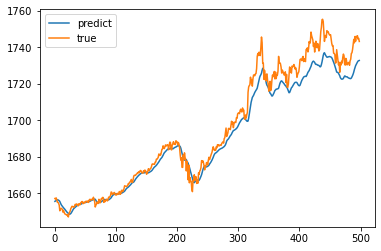

In [12]:
import matplotlib.pyplot as plt

y_pred = pred.detach().numpy()
y_true = y_test.detach().numpy()

y_pred = (y_pred+min_max[testing_company]["min"])*min_max[testing_company]["max"]
y_true = (y_true+min_max[testing_company]["min"])*min_max[testing_company]["max"]

plt.plot(y_pred, label="predict")
plt.plot(y_true, label="true")
plt.legend()
plt.show()